In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Enable GPU and mixed precision
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled")


Mixed precision enabled


In [ ]:

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 100, 75
BATCH_SIZE = 32

# Data directories
train_dir = '/content/drive/MyDrive/split_dataset/train'
test_dir = '/content/drive/MyDrive/split_dataset/test'


In [ ]:

def create_dataframe(data_dir):
    rows = []
    for label, directory in enumerate(sorted(os.listdir(data_dir))):
        sub_dir = os.path.join(data_dir, directory)
        if os.path.isdir(sub_dir):
            for filename in os.listdir(sub_dir):
                image_path = os.path.join(sub_dir, filename)
                rows.append({'image_path': image_path, 'label': label})
    return pd.DataFrame(rows)

# Create DataFrames
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)


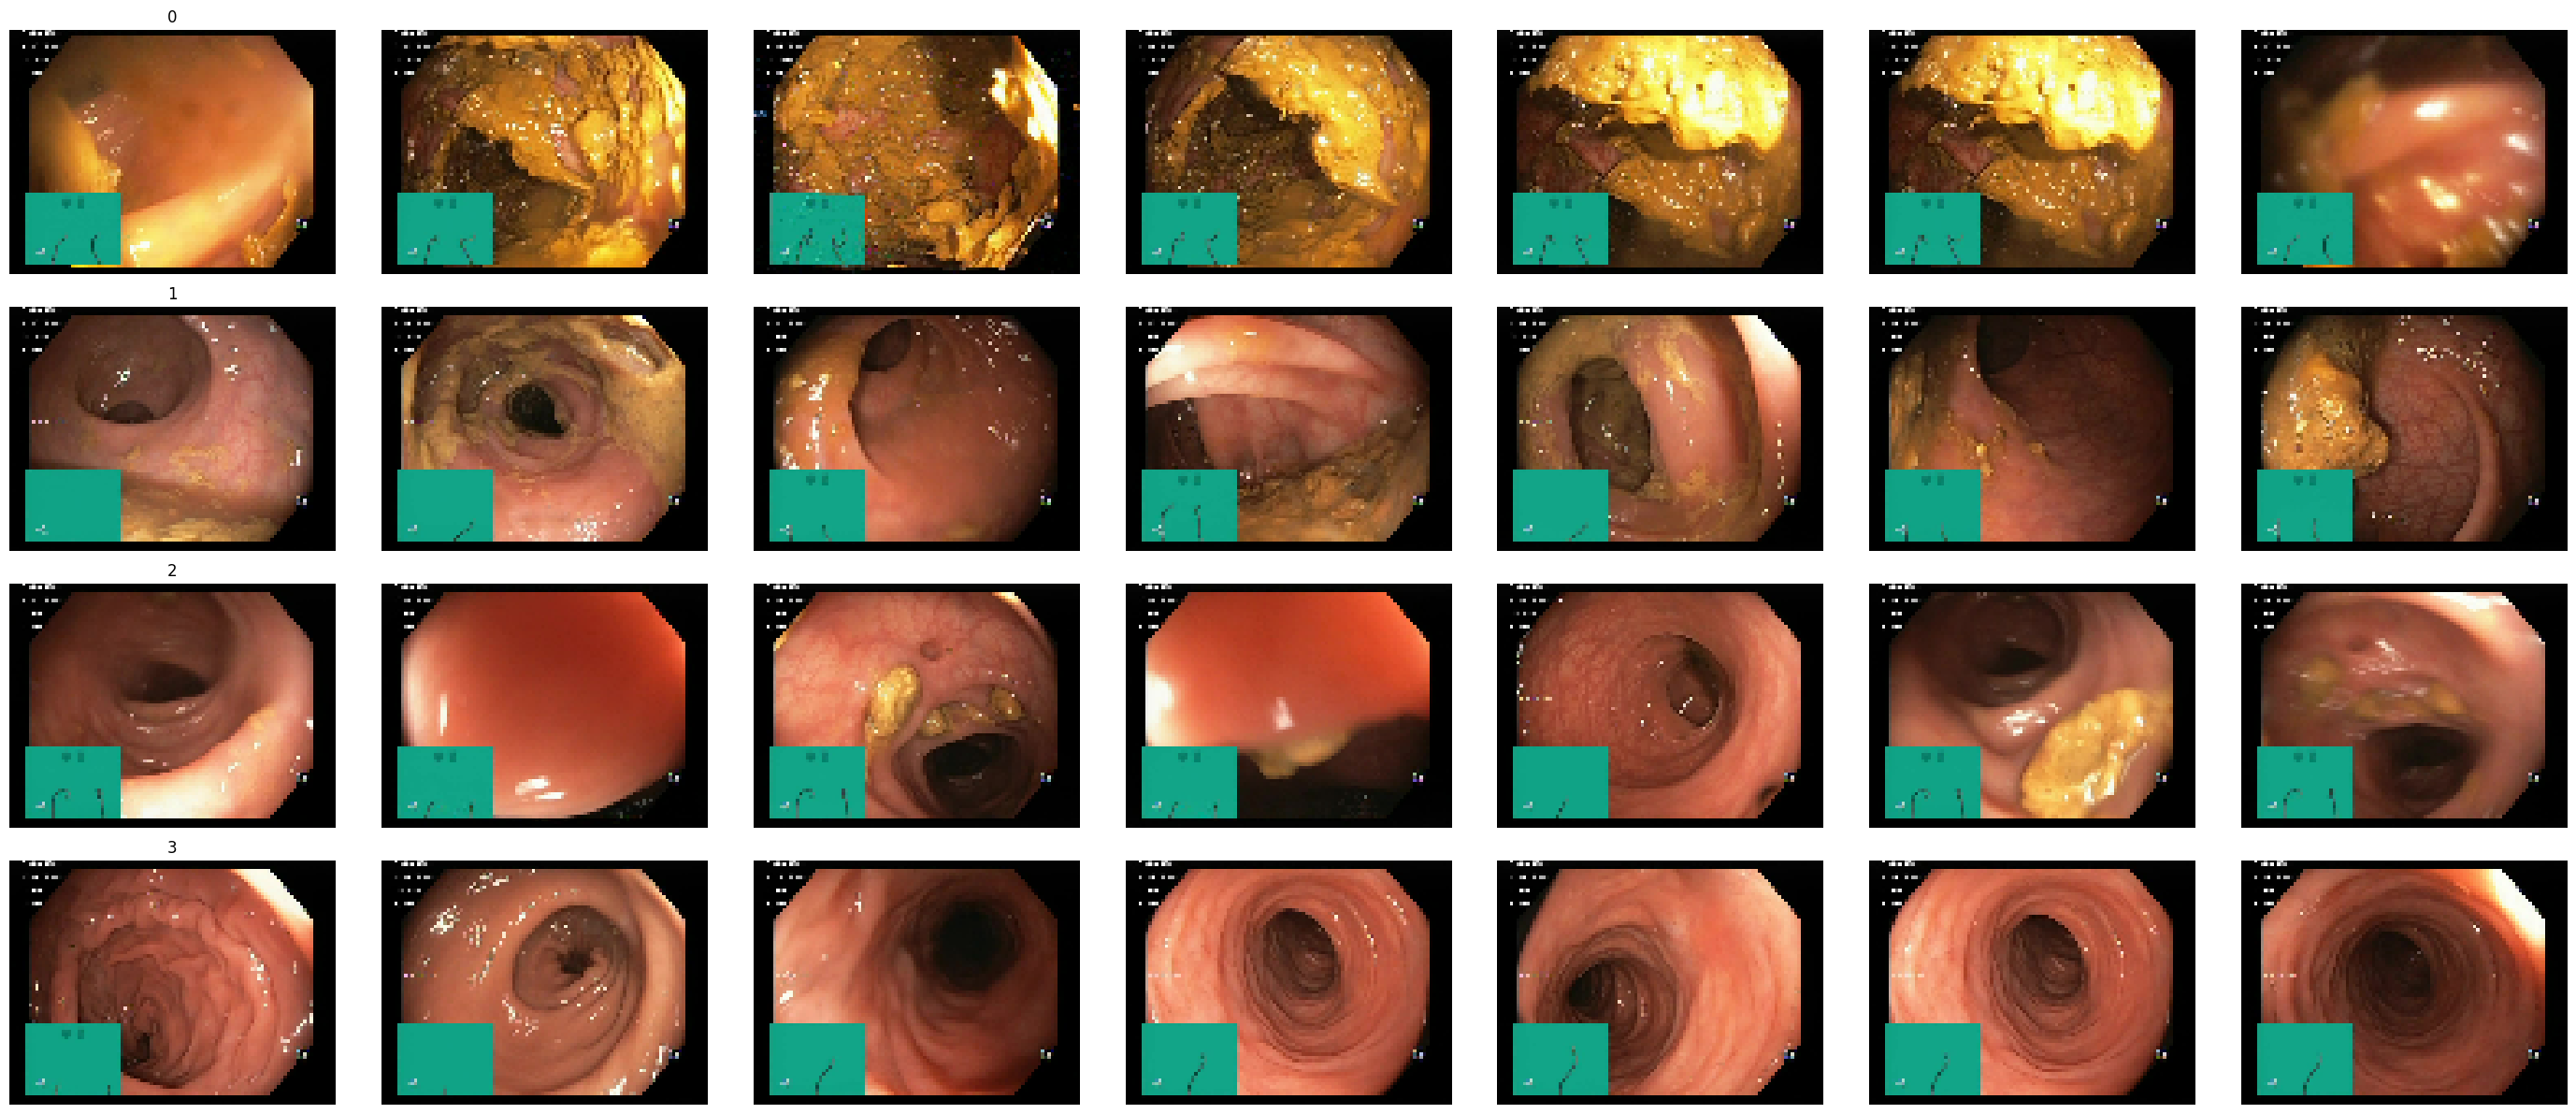

In [ ]:
# After train_df = create_dataframe(train_dir)
label_map = {i: name for i, name in enumerate(sorted(os.listdir(train_dir)))}

# Load sample images to preview them
def load_image_for_plotting(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image.numpy().astype("uint8")

train_df['image'] = train_df['image_path'].apply(load_image_for_plotting)

# Plot sample images from each class
n_samples = 4
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4 * n_samples, 3 * num_classes))
for n_axs, (class_idx, class_rows) in zip(m_axs, train_df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx]
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# Image Preprocessing
def preprocess_image(image):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.image.adjust_contrast(image, 1.5)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Optional Basic Segmentation Placeholder (can replace with U-Net)
def segment_image(image):
    # Convert to grayscale and apply thresholding (placeholder)
    gray = tf.image.rgb_to_grayscale(image)
    threshold = tf.where(gray > 0.5, 1.0, 0.0)
    image = tf.concat([threshold, threshold, threshold], axis=-1)
    return image

In [ ]:
# Image Parsing Function
def parse_image(filename, label, apply_segmentation=False):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess_image(image)
    if apply_segmentation:
        image = segment_image(image)
    return image, label

def create_dataset(df, training=False, apply_segmentation=False):
    ds = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['label'].values))
    ds = ds.map(lambda x, y: parse_image(x, y, apply_segmentation), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# TensorFlow datasets
train_ds = create_dataset(train_df, training=True, apply_segmentation=True)
test_ds = create_dataset(test_df, training=False, apply_segmentation=True)


In [ ]:

# Optional: Data Augmentation via GAN (Placeholder: You must pre-train a GAN separately)
def augment_with_gan(original_df):
    # Simulated GAN output augmentation
    gan_augmented_images = []  # You'd load or generate GAN images here
    # For now, we assume you've added them manually to dataset
    return original_df  # Placeholder; no actual GAN logic included here


In [ ]:

# Model Definition
def create_cnn_model(num_classes):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inputs, outputs)


In [ ]:

# Number of classes
num_classes = train_df['label'].nunique()

# Model compilation
model = create_cnn_model(num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks
best_model_cb = callbacks.ModelCheckpoint("best_cnn_model.h5", save_best_only=True, monitor='val_accuracy')
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)


In [ ]:

# Train
history = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=[best_model_cb, early_stop, reduce_lr])

# Load best model
model.load_weights("best_cnn_model.h5")


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7778 - loss: 0.5197

178/178 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.7778 - loss: 0.5201 - val_accuracy: 0.3956 - val_loss: 1.5590 - learning_rate: 1.0000e-04
Epoch 2/10
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7738 - loss: 0.6657

178/178 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.7744 - loss: 0.6641 - val_accuracy: 0.5671 - val_loss: 1.0282 - learning_rate: 1.0000e-04
Epoch 3/10
175/178 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8657 - loss: 0.3939

178/178 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step - accuracy: 0.8662 - loss: 0.3929 - val_accuracy: 0.7058 - val_loss: 0.7157 - learning_rate: 1.0000e-04
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.8917 - loss: 0.3066 - val_accuracy: 0.6924 - val_loss: 0.7621 - learning_rate: 1.0000e-04
Epoch 5/10
174/178 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9111 - loss: 0.2215

178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.9119 - loss: 0.2204 - val_accuracy: 0.8391 - val_loss: 0.4504 - learning_rate: 1.0000e-04
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9353 - loss: 0.1609

178/178 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.9354 - loss: 0.1607 - val_accuracy: 0.9209 - val_loss: 0.3087 - learning_rate: 1.0000e-04
Epoch 7/10
174/178 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9581 - loss: 0.1199

178/178 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.9585 - loss: 0.1193 - val_accuracy: 0.9449 - val_loss: 0.2508 - learning_rate: 1.0000e-04
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9627 - loss: 0.0901

178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.9627 - loss: 0.0900 - val_accuracy: 0.9493 - val_loss: 0.2493 - learning_rate: 1.0000e-04
Epoch 9/10
175/178 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9681 - loss: 0.0807

178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9684 - loss: 0.0800 - val_accuracy: 0.9538 - val_loss: 0.2291 - learning_rate: 1.0000e-04
Epoch 10/10
174/178 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9703 - loss: 0.0768

178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.9707 - loss: 0.0760 - val_accuracy: 0.9716 - val_loss: 0.2074 - learning_rate: 1.0000e-04


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step


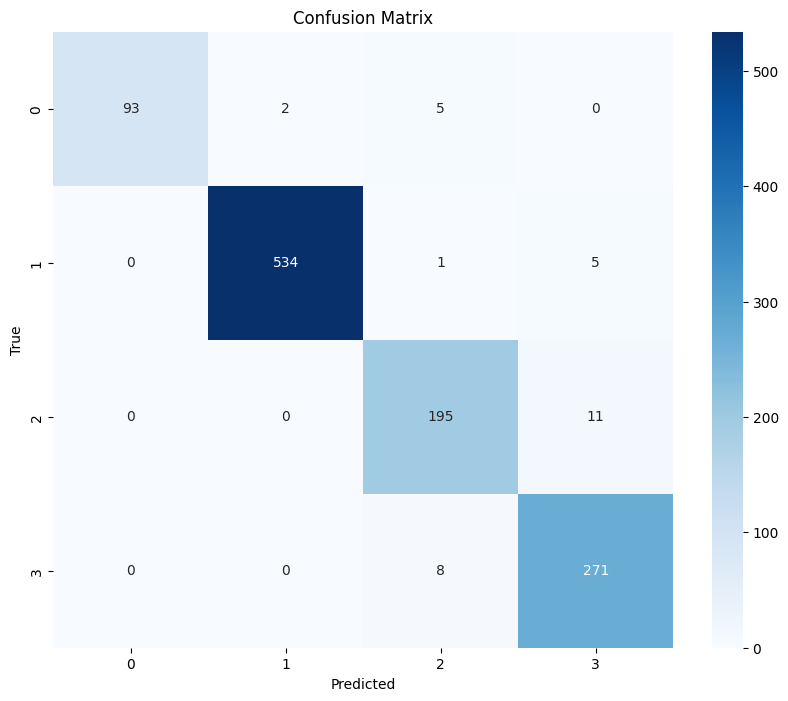

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       100
           1       1.00      0.99      0.99       540
           2       0.93      0.95      0.94       206
           3       0.94      0.97      0.96       279

    accuracy                           0.97      1125
   macro avg       0.97      0.96      0.96      1125
weighted avg       0.97      0.97      0.97      1125



In [ ]:

# Evaluate
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))